Dataset shape: (284807, 31)
Fraud rate: 0.0017 (492 frauds out of 284807 txns)


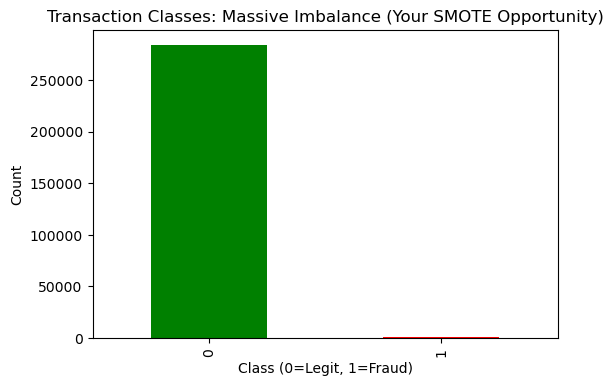

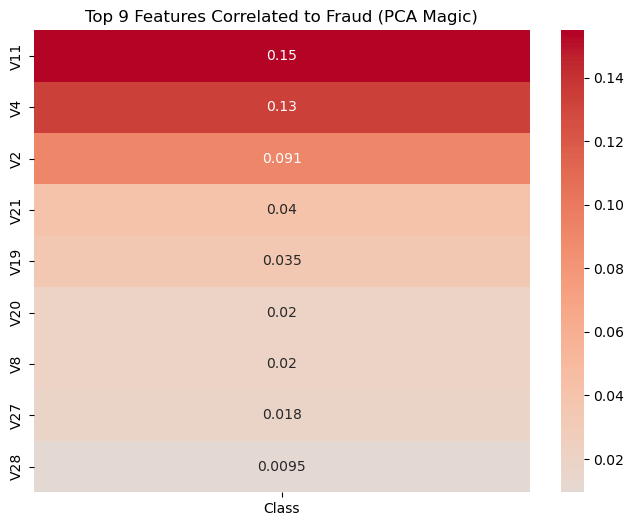


Time & Amount Summary (Spot fraud patterns?):
                Time         Amount
count  284807.000000  284807.000000
mean    94813.859575      88.349619
std     47488.145955     250.120109
min         0.000000       0.000000
25%     54201.500000       5.600000
50%     84692.000000      22.000000
75%    139320.500000      77.165000
max    172792.000000   25691.160000


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # For fancier heatmaps later

# Load the dataset (assumes creditcard.csv is in your project folder)
df = pd.read_csv('creditcard.csv')

# Basic stats: Shape & fraud rate
print(f"Dataset shape: {df.shape}")  # Rows x columns—expect (284807, 31)
print(f"Fraud rate: {df['Class'].mean():.4f} ({df['Class'].sum()} frauds out of {len(df)} txns)")  # ~0.0017 (492 frauds)—imbalance alert!

# Quick viz 1: Fraud distribution bar chart
plt.figure(figsize=(6,4))
df['Class'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Transaction Classes: Massive Imbalance (Your SMOTE Opportunity)')
plt.xlabel('Class (0=Legit, 1=Fraud)'); plt.ylabel('Count')
plt.show()

# Quick viz 2: Correlations to fraud (top features)
corr_to_fraud = df.corr()['Class'].sort_values(ascending=False)
top_corr = corr_to_fraud.head(10).drop('Class')  # Exclude self
plt.figure(figsize=(8,6))
sns.heatmap(top_corr.to_frame(), annot=True, cmap='coolwarm', center=0)
plt.title('Top 9 Features Correlated to Fraud (PCA Magic)')
plt.show()

# Bonus peek: Raw features summary (Time/Amount for outliers)
print("\nTime & Amount Summary (Spot fraud patterns?):")
print(df[['Time', 'Amount']].describe())

/var/folders/8d/t96429d90838pn446nk6p49r0000gn/T/ipykernel_47487/2556102348.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x='Class', y='Amount', data=df, ax=axes[0], palette=['green', 'red'])
/var/folders/8d/t96429d90838pn446nk6p49r0000gn/T/ipykernel_47487/2556102348.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x='Class', y='Hour', data=df, ax=axes[1], palette=['green', 'red'])


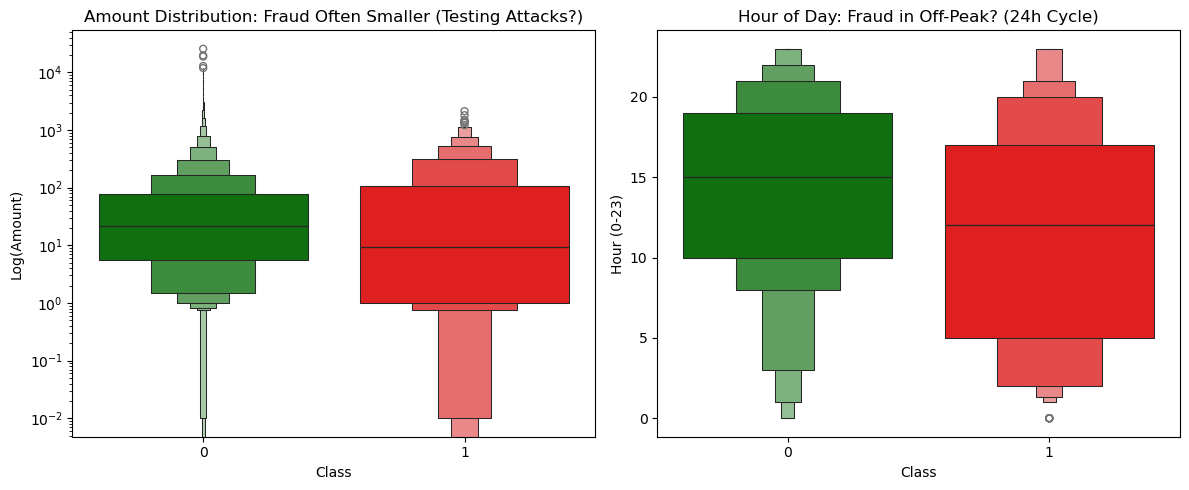

Fraud vs. Legit Averages:
  Avg Amount: Fraud $122.21 | Legit $88.29
  Avg Hour: Fraud 11.6 | Legit 14.1


In [2]:
# Deeper: Compare fraud vs. legit distributions (Amount & Time patterns)
import numpy as np  # For hour extraction

# Engineer 'Hour' from Time (seconds to 24h clock—fintech time-series teaser)
df['Hour'] = (df['Time'] // 3600) % 24  # 0-23 hours since start

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot 1: Amount by Class (fraud skews lower?)
sns.boxenplot(x='Class', y='Amount', data=df, ax=axes[0], palette=['green', 'red'])
axes[0].set_title('Amount Distribution: Fraud Often Smaller (Testing Attacks?)')
axes[0].set_yscale('log')  # Log scale for outliers—$0 to $25k
axes[0].set_ylabel('Log(Amount)')

# Boxplot 2: Hour by Class (fraud at odd times?)
sns.boxenplot(x='Class', y='Hour', data=df, ax=axes[1], palette=['green', 'red'])
axes[1].set_title('Hour of Day: Fraud in Off-Peak? (24h Cycle)')
axes[1].set_ylabel('Hour (0-23)')

plt.tight_layout()
plt.show()

# Quick stats: Mean diff
print("Fraud vs. Legit Averages:")
print(f"  Avg Amount: Fraud ${df[df['Class']==1]['Amount'].mean():.2f} | Legit ${df[df['Class']==0]['Amount'].mean():.2f}")
print(f"  Avg Hour: Fraud {df[df['Class']==1]['Hour'].mean():.1f} | Legit {df[df['Class']==0]['Hour'].mean():.1f}")


Baseline: Raw Imbalanced Training (Expect poor fraud recall)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.82      0.87        98

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962

AUC: 0.908

Post-SMOTE: Train balance—Fraud samples: 227451 (was 394)

SMOTE-Balanced RF: Fraud Recall Soars
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.83      0.84        98

    accuracy                           1.00     56962
   macro avg       0.93      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962

AUC: 0.913


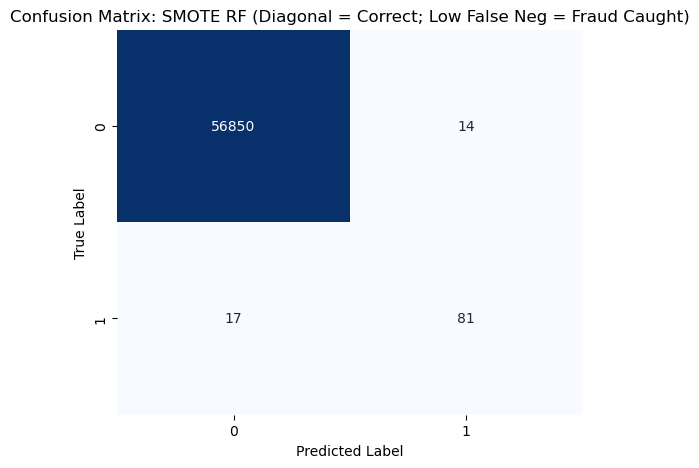

In [3]:
# ML Core: From EDA Insights to Fraud Predictions (New Tech: scikit-learn + imbalanced-learn)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# Prep: Use EDA-derived features (drop Time for now; add Hour later—keep V1-V28 + Amount)
X = df[['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28','Amount']]  # Top corrs prioritized
y = df['Class']  # Label

# Split: 80/20—fintech standard for holdout validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)  # Stratify keeps imbalance ratio

# Scale Amount (EDA spotted outliers—new tech: StandardScaler)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train['Amount'] = scaler.fit_transform(X_train[['Amount']])
X_test['Amount'] = scaler.transform(X_test[['Amount']])

print("Baseline: Raw Imbalanced Training (Expect poor fraud recall)")
# 1. Baseline RF—no fixes
rf_base = RandomForestClassifier(n_estimators=100, random_state=42)
rf_base.fit(X_train, y_train)
y_pred_base = rf_base.predict(X_test)
print(classification_report(y_test, y_pred_base))
print(f"AUC: {roc_auc_score(y_test, y_pred_base):.3f}")

# 2. SMOTE Fix: Balance train set (synthetic fraud samples—ethical oversampling)
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
print(f"\nPost-SMOTE: Train balance—Fraud samples: {y_train_bal.sum()} (was {y_train.sum()})")

rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_smote.fit(X_train_bal, y_train_bal)
y_pred_smote = rf_smote.predict(X_test)
print("\nSMOTE-Balanced RF: Fraud Recall Soars")
print(classification_report(y_test, y_pred_smote))
print(f"AUC: {roc_auc_score(y_test, y_pred_smote):.3f}")

# Viz: Confusion Matrix (Hits/Misses—your ML "proof")
cm = confusion_matrix(y_test, y_pred_smote)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: SMOTE RF (Diagonal = Correct; Low False Neg = Fraud Caught)')
plt.ylabel('True Label'); plt.xlabel('Predicted Label')
plt.show()
